In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm

In [2]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [3]:
test_id = test['Id']

In [4]:
df = train

In [5]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

In [7]:
train = df

In [8]:
print(f"Number of rows and number of columns in the train dataset are {train.shape[0]} and {train.shape[1]}")
print(f"Number of rows and number of columns in the test dataset are {test.shape[0]} and {test.shape[1]}")

Number of rows and number of columns in the train dataset are 1460 and 80
Number of rows and number of columns in the test dataset are 1459 and 79


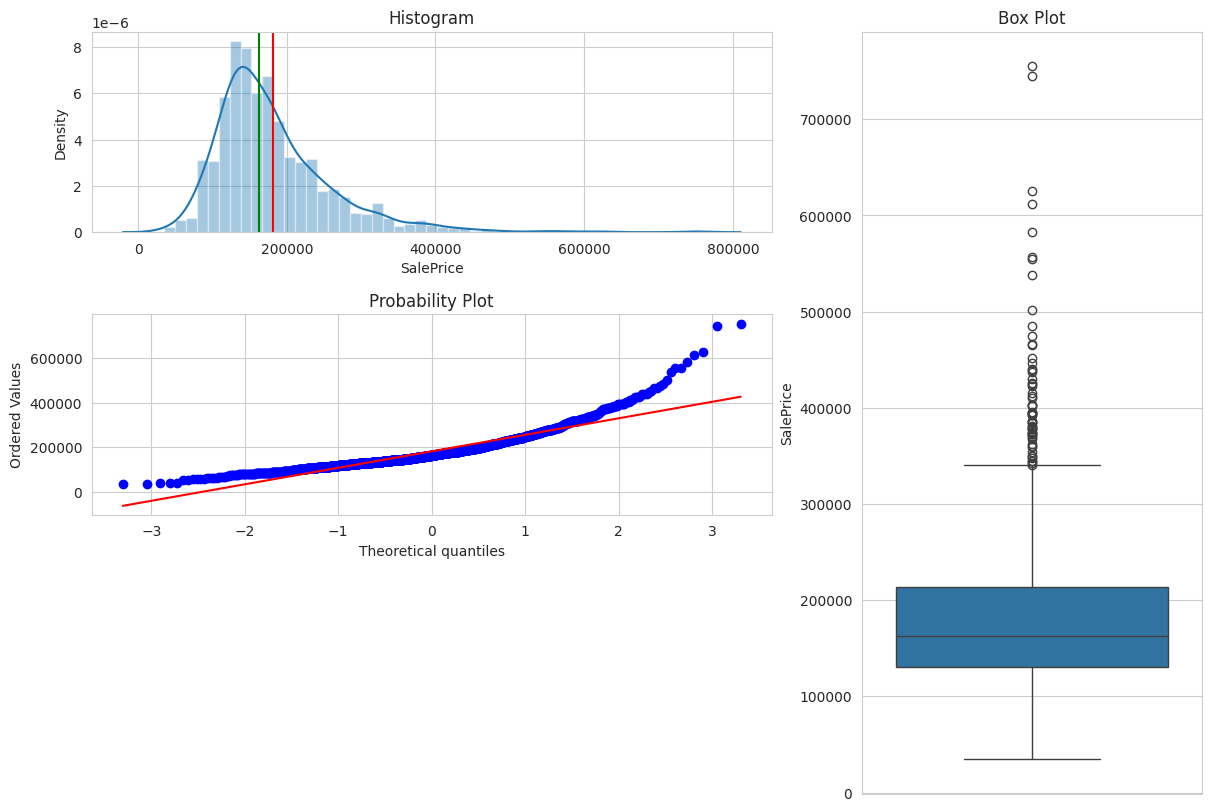

In [9]:
def three_chart_plot(df, feature):
    fig = plt.figure(constrained_layout = True, figsize = (12, 8))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)

    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')

    sns.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')

    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title.
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient = 'v', ax = ax3 )

three_chart_plot(df, 'SalePrice')

In [10]:
from scipy.stats import skew
print("Skewness of the SalesPrice is", df['SalePrice'].skew())

Skewness of the SalesPrice is 1.8828757597682129


<Axes: >

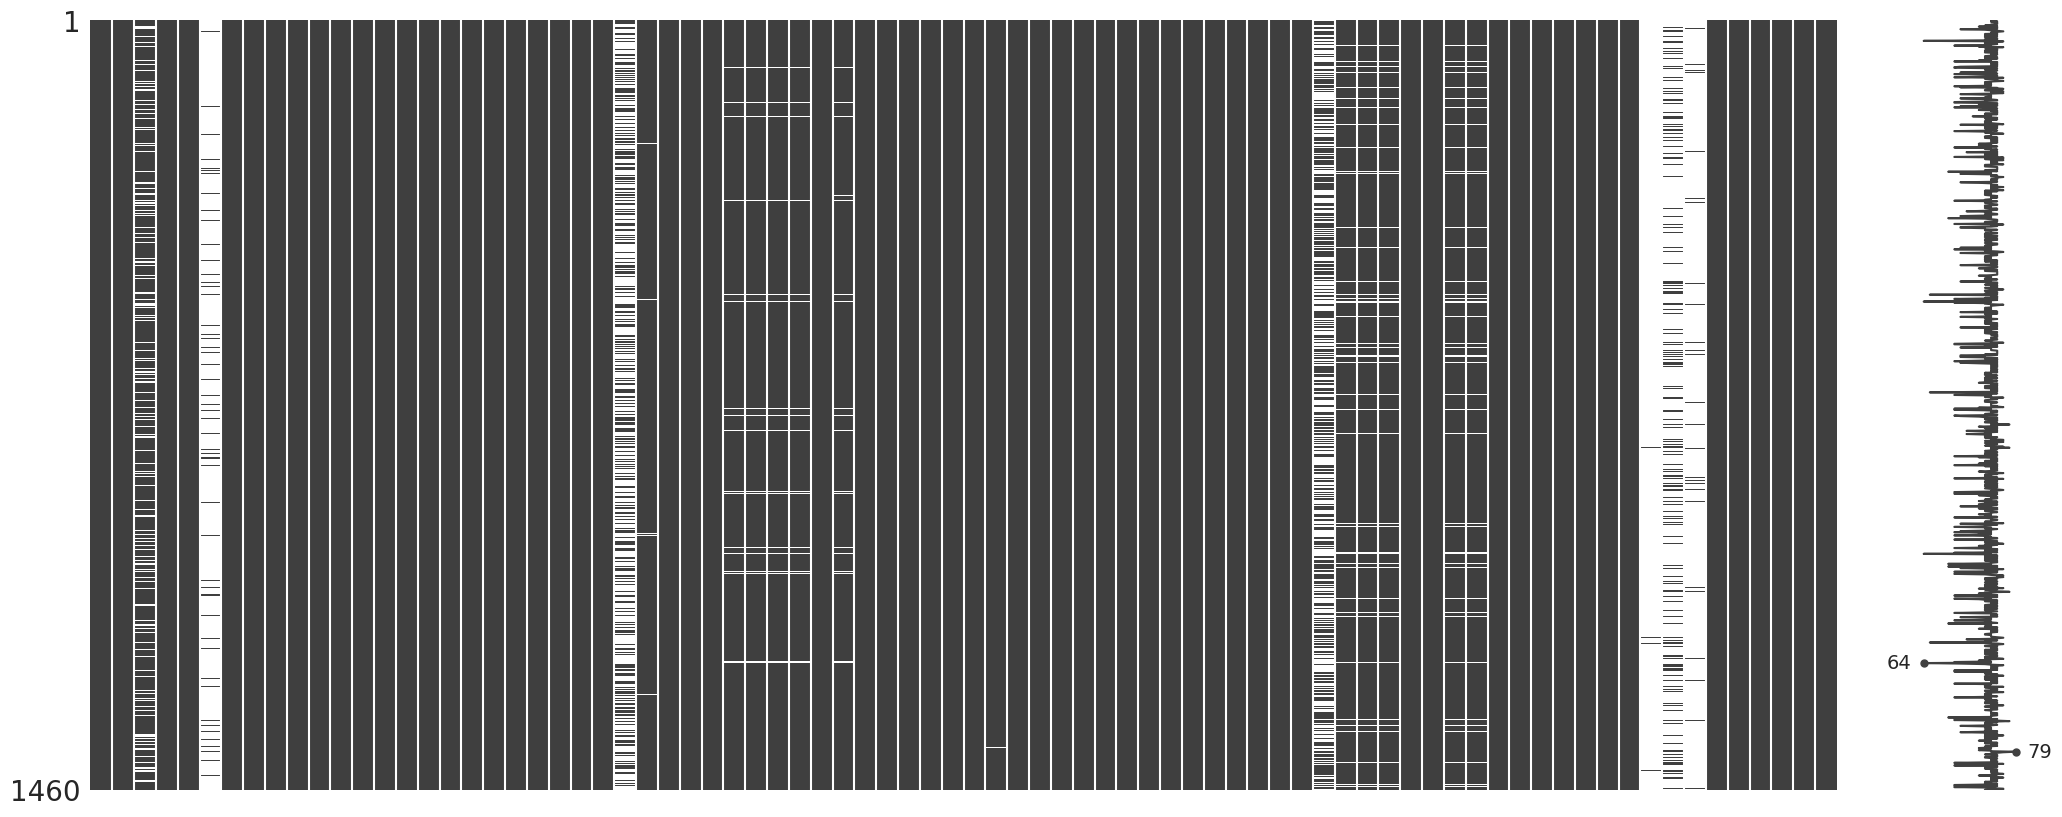

In [11]:
import missingno as msno
%matplotlib inline
msno.matrix(train)

<Axes: >

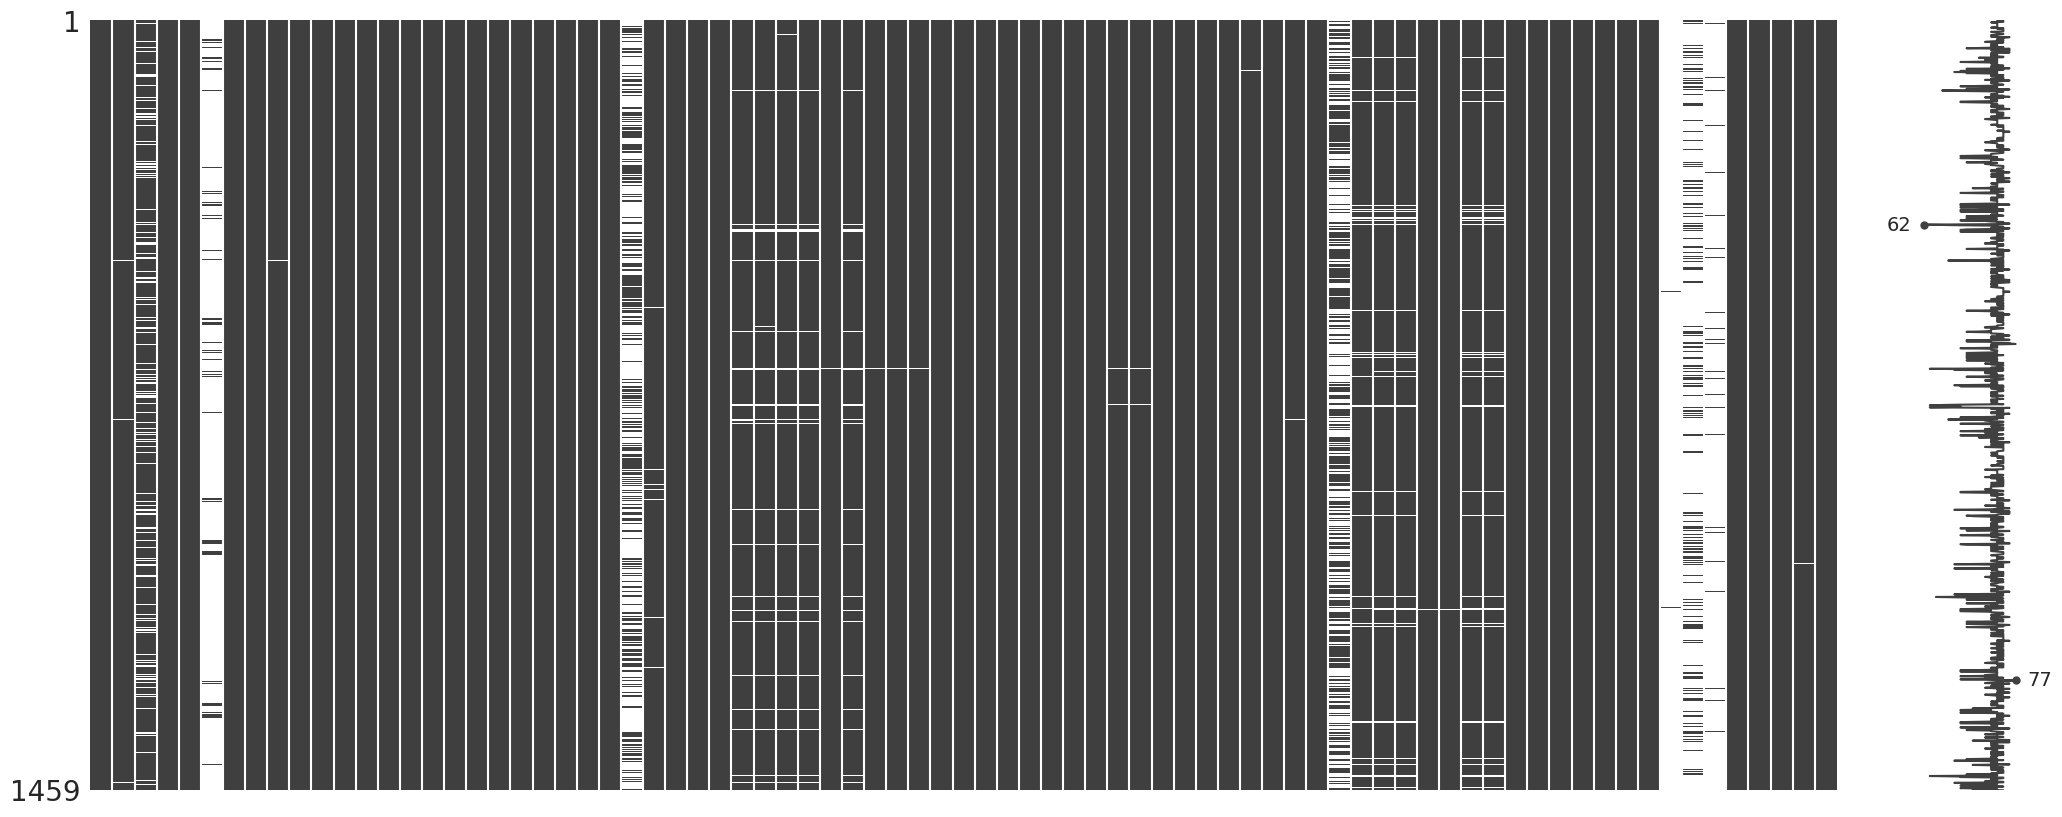

In [12]:
msno.matrix(test)

In [13]:
def null_table(data):
    """
    A function which returns the number and percentage of null values in the given dataset.
    """
    indices = data.isnull().sum().index
    values = data.isnull().sum().values
    percentages = []
    for i in indices:
        percentages.append((data[i].isnull().sum() / data[i].shape[0]) * 100)
    d = {'Columns' : indices, 'Count of Null Values' : values, 'Approximate Percentage of Null Values' : percentages}
    # data = dict(zip(indices, percentages))
    null_frame = pd.DataFrame(data = d)
    return null_frame

In [14]:
null_frame_train = null_table(df)
null_frame_train.sort_values(by = 'Approximate Percentage of Null Values').tail(10)

,Columns,Count of Null Values,Approximate Percentage of Null Values
59,GarageFinish,81,5.547945
62,GarageQual,81,5.547945
58,GarageYrBlt,81,5.547945
2,LotFrontage,259,17.739726
56,FireplaceQu,690,47.260274
24,MasVnrType,872,59.726027
72,Fence,1179,80.753425
5,Alley,1369,93.767123
73,MiscFeature,1406,96.301370
71,PoolQC,1453,99.520548


In [15]:
null_frame_test = null_table(test)
null_frame_test.sort_values(by = 'Approximate Percentage of Null Values').tail(10)

,Columns,Count of Null Values,Approximate Percentage of Null Values
63,GarageCond,78,5.346127
59,GarageFinish,78,5.346127
62,GarageQual,78,5.346127
2,LotFrontage,227,15.558602
56,FireplaceQu,730,50.034270
24,MasVnrType,894,61.274846
72,Fence,1169,80.123372
5,Alley,1352,92.666210
73,MiscFeature,1408,96.504455
71,PoolQC,1456,99.794380


In [16]:
na = train.shape[0]
nb = test.shape[0]
y_train = train['SalePrice'].to_frame()
# Combine train and test sets
total = pd.concat((train, test), sort = False).reset_index(drop = True)
# Drop the target "SalePrice" and Id columns
total.drop(['SalePrice'], axis = 1, inplace = True)
print(f"Total size is {total.shape}")

Total size is (2919, 79)


In [17]:
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):

    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')

    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )

    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')

    return plt.show()

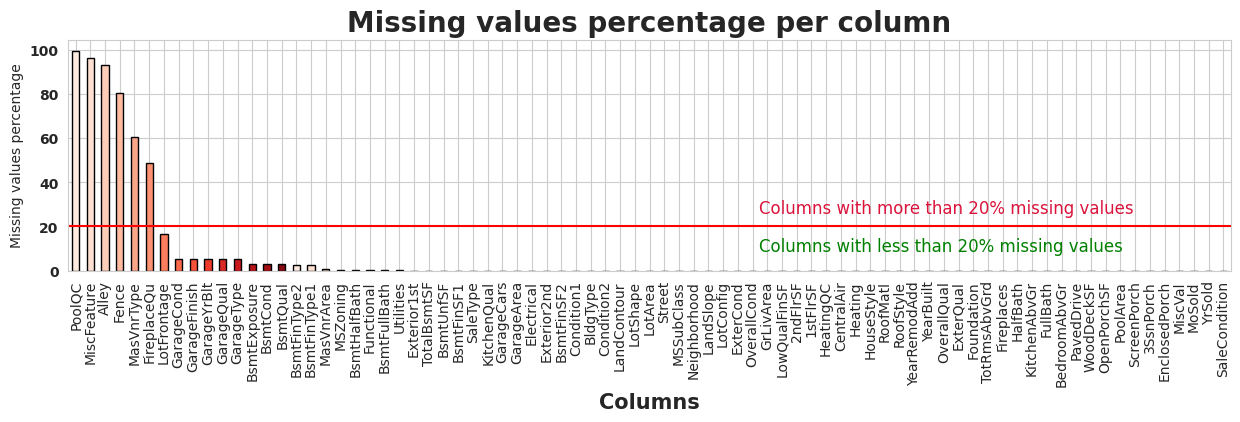

In [18]:
msv_1(total, 20, color=sns.color_palette('Reds',15))

In [19]:
category_var = df.select_dtypes(include = 'object')
num_var = df.select_dtypes(exclude = 'object')

print("Number of categorical features are: ", category_var.shape[1])
print("Number of numerical features are: ", num_var.shape[1])

Number of categorical features are:  43
Number of numerical features are:  37


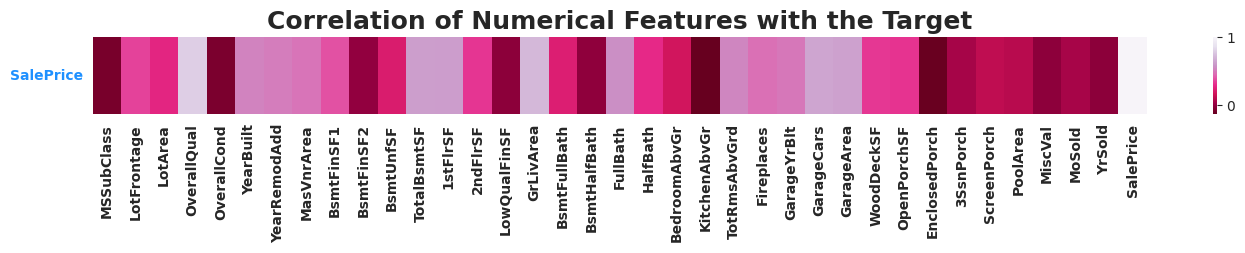

In [20]:
num = df.select_dtypes(exclude = 'object')
corr_num = num.corr()

f, ax = plt.subplots(figsize = (17, 1))

sns.heatmap(corr_num.sort_values(by = ['SalePrice'], ascending = False).head(1), cmap='PuRd_r')

plt.title('Correlation of Numerical Features with the Target', weight = 'bold', fontsize = 18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

plt.show()

In [30]:
correlation = df.select_dtypes(include=[np.number]).corr()['SalePrice'].sort_values(ascending=False).to_frame().head(10)

cmap = sns.light_palette("cyan", as_cmap=True)

s = correlation.style.background_gradient(cmap=cmap)

s


,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


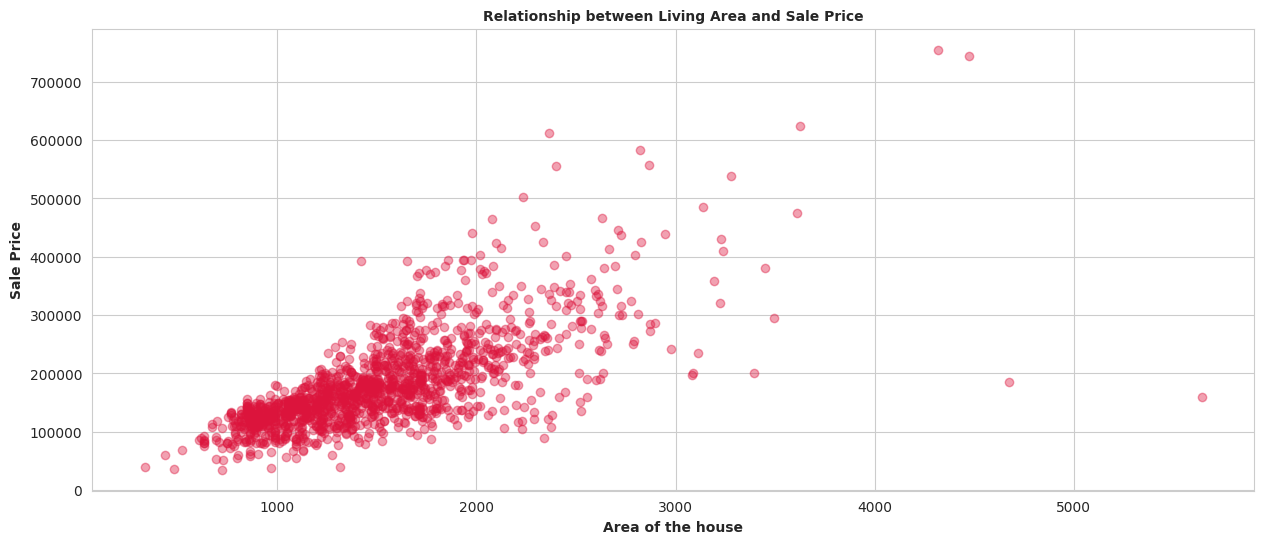

In [31]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Living Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the house', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

In [32]:
train = train[train['GrLivArea'] < 4500]
previous_train = df
df = train

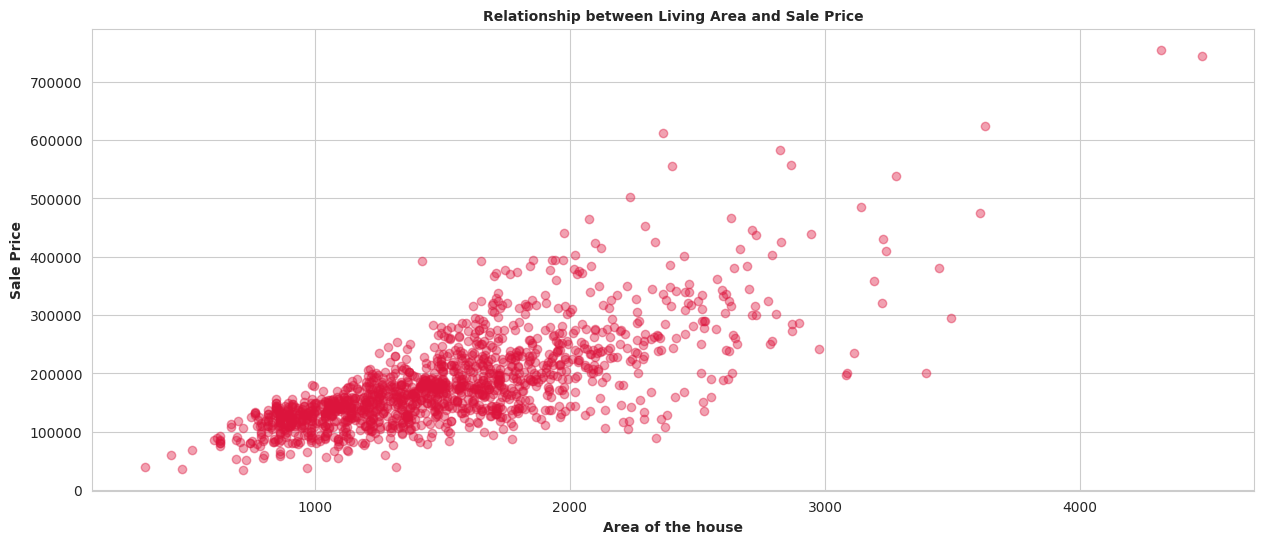

In [33]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Living Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the house', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

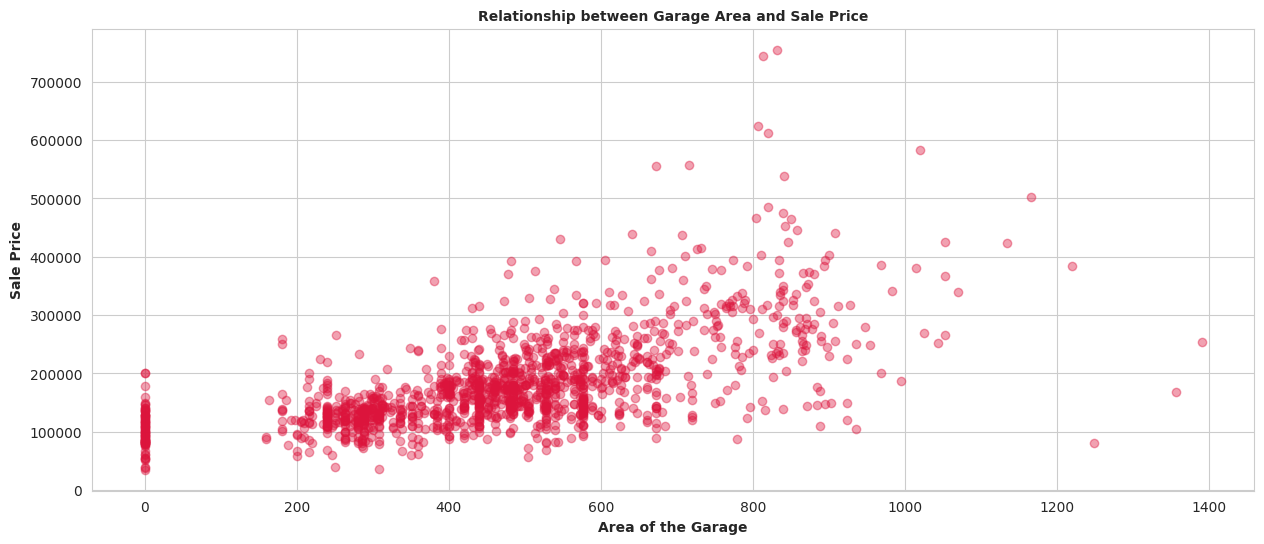

In [34]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GarageArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Garage Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the Garage', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

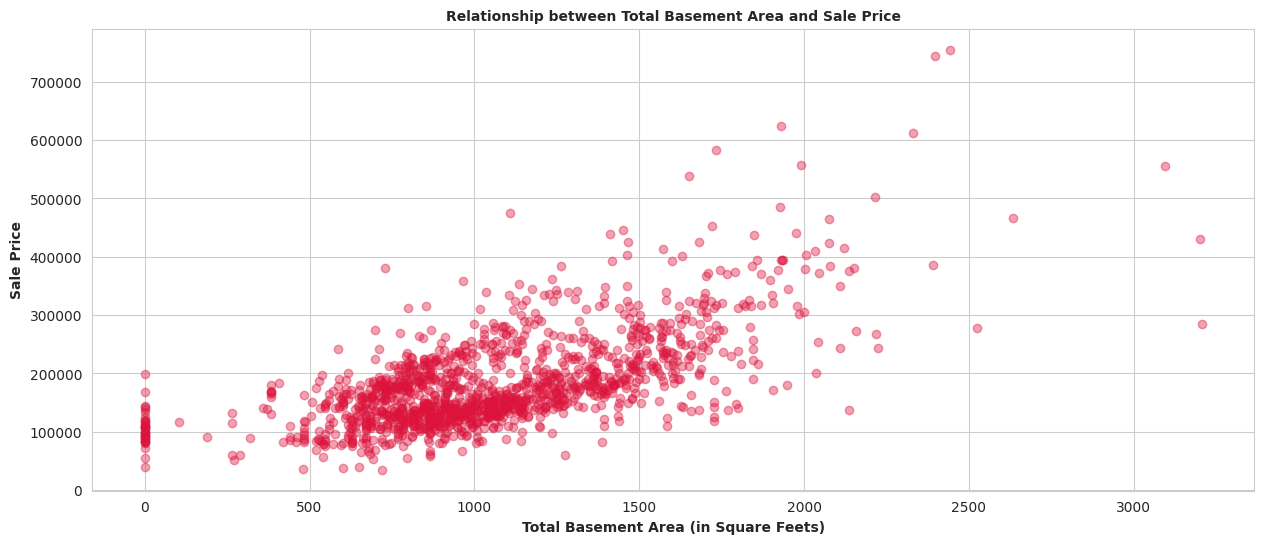

In [35]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'TotalBsmtSF', y = 'SalePrice', data = df, color = 'crimson', alpha = 0.4)
plt.title('Relationship between Total Basement Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Total Basement Area (in Square Feets)', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

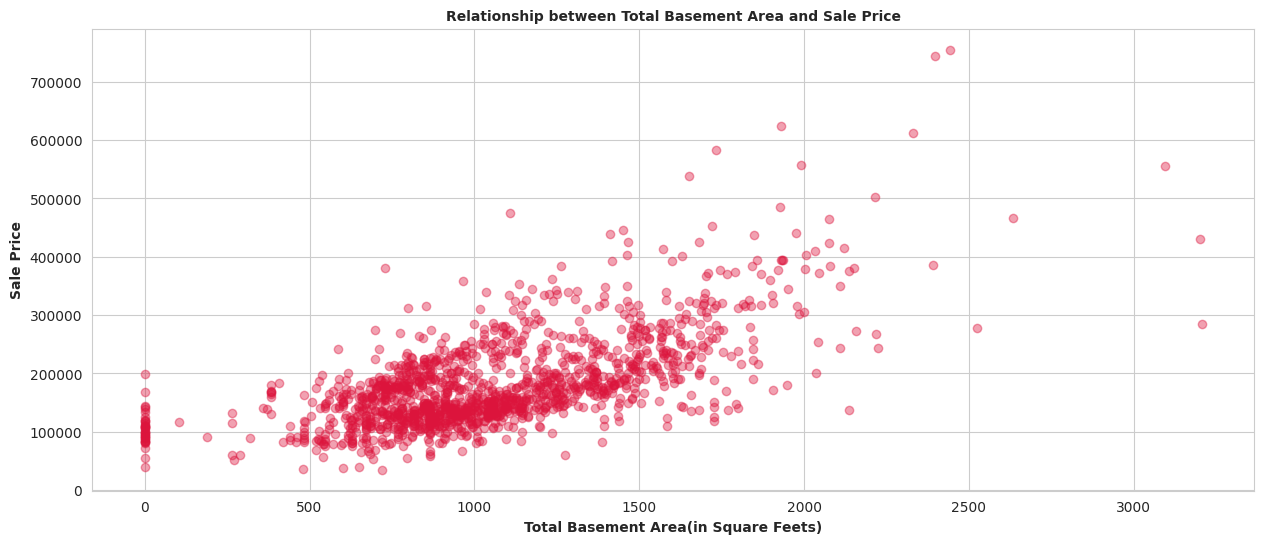

In [36]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'TotalBsmtSF', y = 'SalePrice', data = df, color = 'crimson', alpha = 0.4)
plt.title('Relationship between Total Basement Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Total Basement Area(in Square Feets)', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

<Axes: xlabel='MasVnrArea', ylabel='SalePrice'>

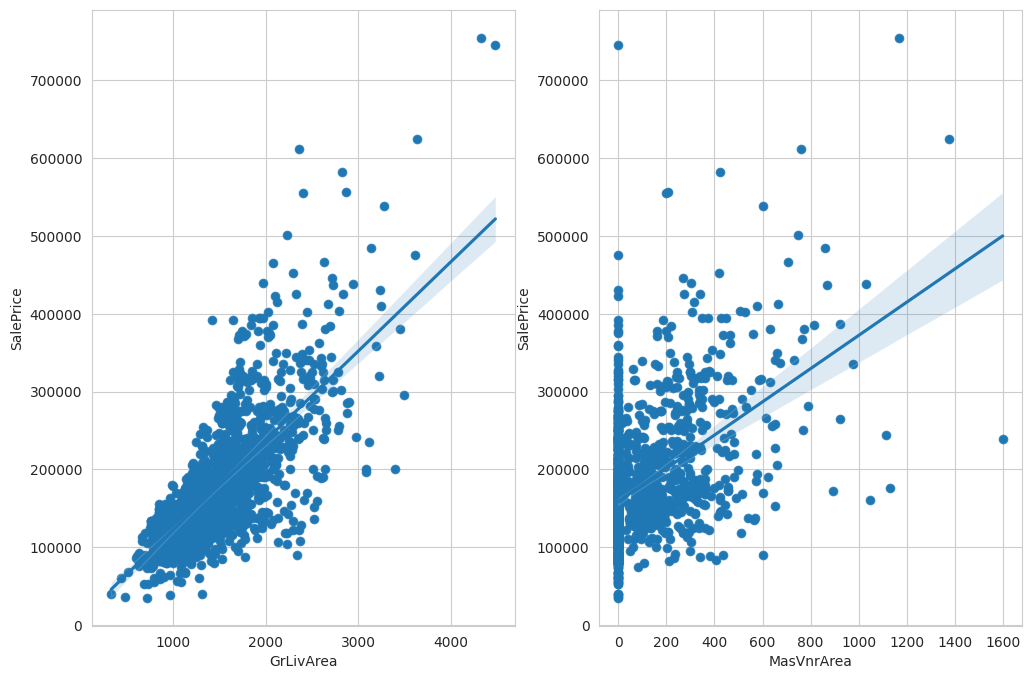

In [37]:
## Scatter plotting for SalePrice and GrLivArea.
fig, (ax1, ax2) = plt.subplots(figsize = (12, 8), ncols = 2,sharey = False)

sns.scatterplot(x = df['GrLivArea'], y = df['SalePrice'],  ax = ax1)
## Putting a regression line.
sns.regplot(x = df['GrLivArea'], y = df['SalePrice'], ax = ax1)

sns.scatterplot(x = df['MasVnrArea'],y = df['SalePrice'], ax = ax2)
## regression line for MasVnrArea and SalePrice.
sns.regplot(x = df['MasVnrArea'], y = df['SalePrice'], ax=ax2)

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

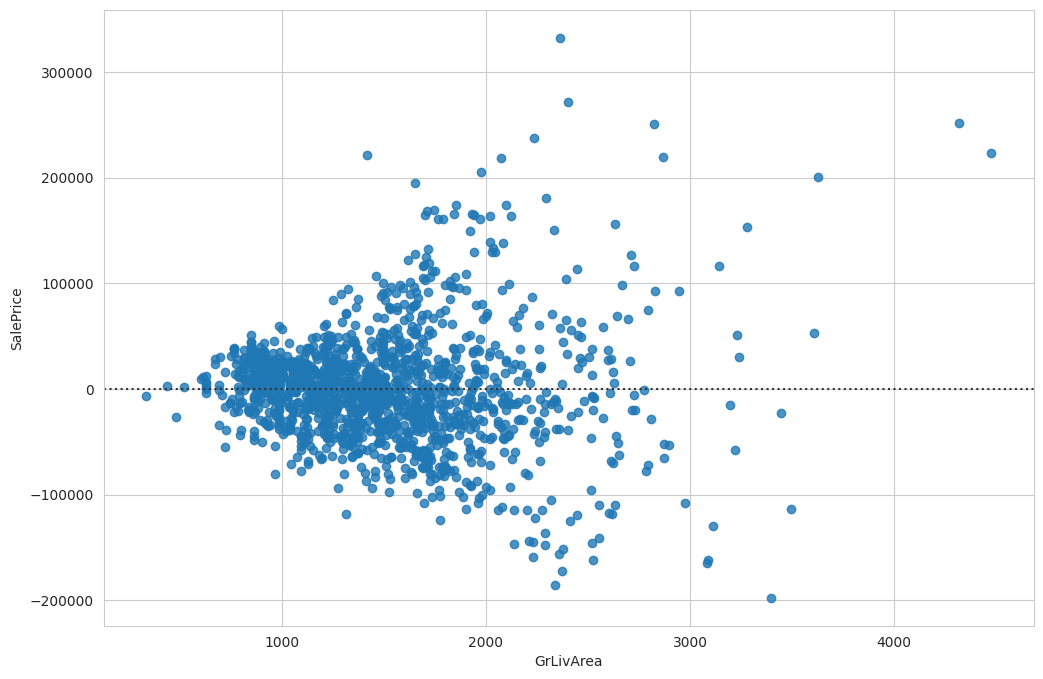

In [39]:
plt.subplots(figsize=(12, 8))
sns.residplot(x=df['GrLivArea'], y=df['SalePrice'])


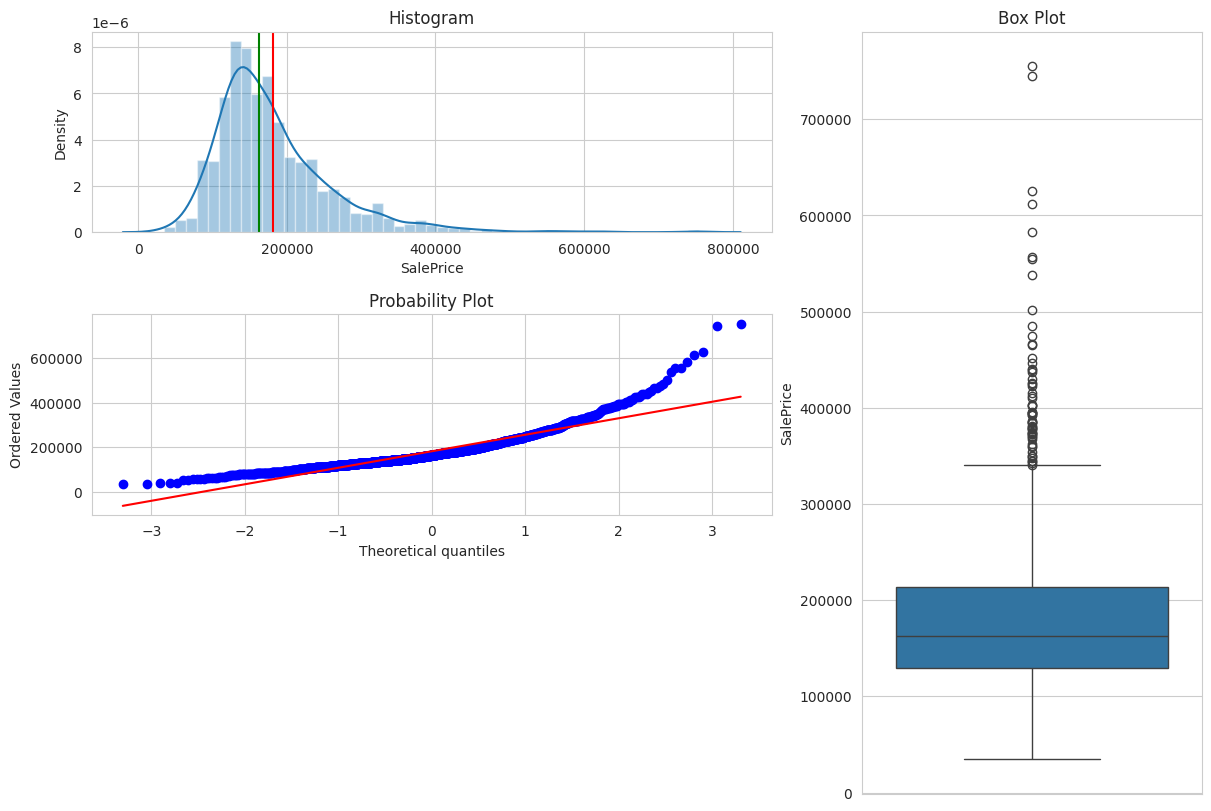

In [40]:
three_chart_plot(df, 'SalePrice')

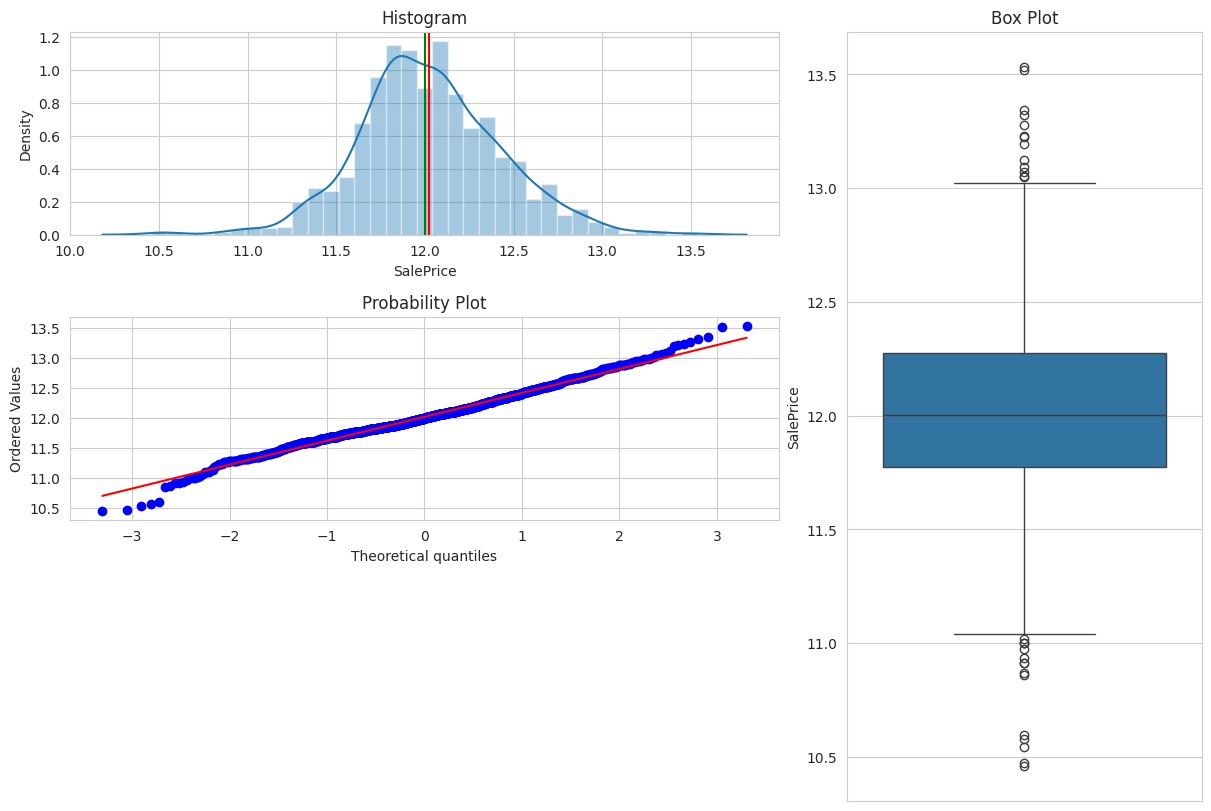

In [41]:
train["SalePrice"] = np.log1p(train["SalePrice"])
df = train
three_chart_plot(df, 'SalePrice')

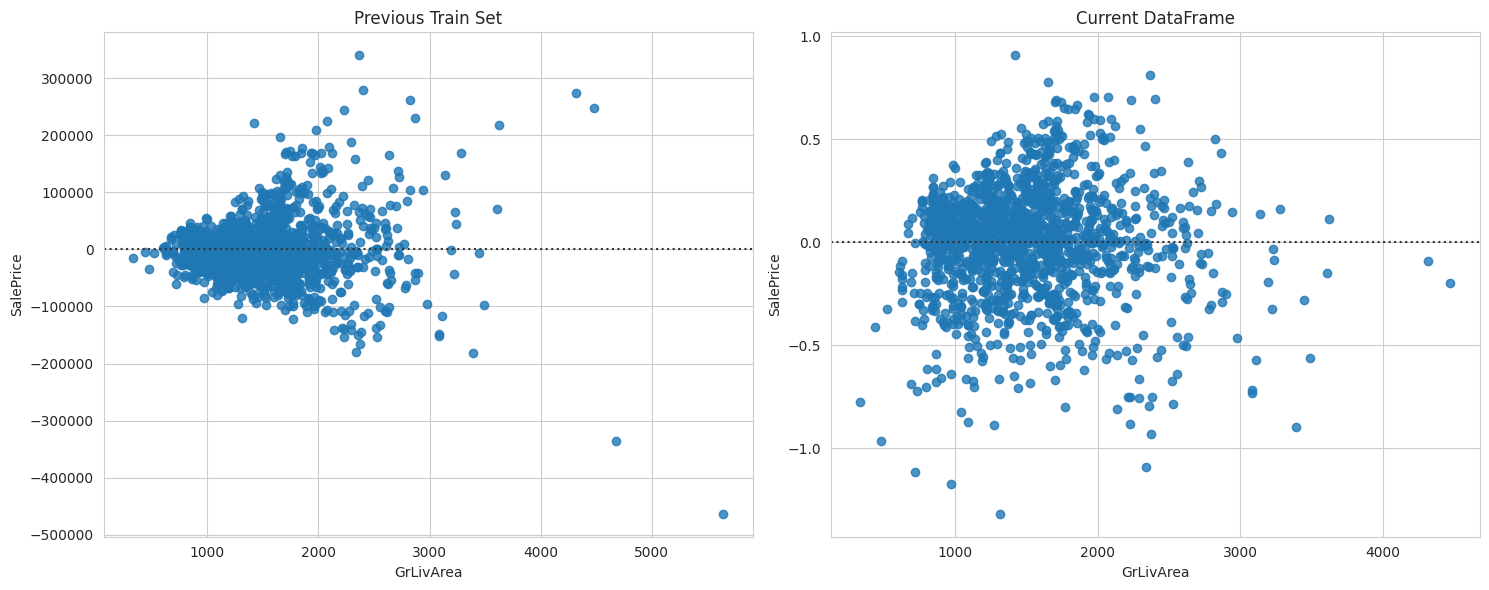

In [43]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 6), ncols=2, sharey=False, sharex=False)

sns.residplot(x=previous_train['GrLivArea'], y=previous_train['SalePrice'], ax=ax1)
ax1.set_title("Previous Train Set")

sns.residplot(x=df['GrLivArea'], y=df['SalePrice'], ax=ax2)
ax2.set_title("Current DataFrame")

plt.tight_layout()
plt.show()


<Figure size 1500x1000 with 0 Axes>

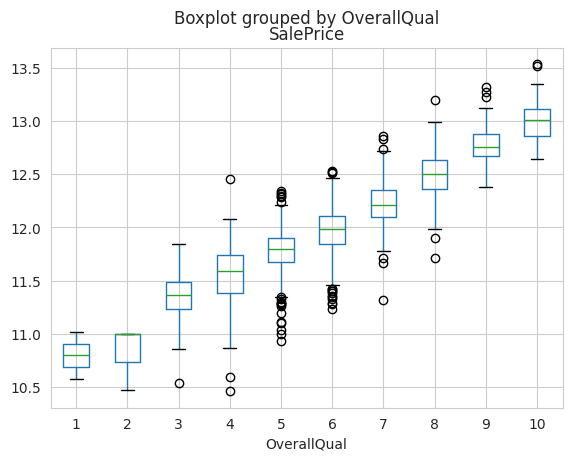

In [44]:
plt.figure(figsize = ((15, 10)))
df.boxplot(by = 'OverallQual', column = 'SalePrice')
plt.show()

In [45]:
def horizontal_plot(data, column_name, color, plot_title):

    """
    A function that plots a horizontal bar graph for the given column name
    """

    fig, ax = plt.subplots(figsize = (9, 6))

    title_cnt = data[column_name].value_counts().sort_values(ascending = False).reset_index()

    mn = ax.barh(title_cnt.iloc[:, 0], title_cnt.iloc[:, 1], edgecolor = 'black', color =
                sns.color_palette(color, len(title_cnt)))

    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)

    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)

    # Add x,y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

    # Show top values
    ax.invert_yaxis()

    ax.set_title(plot_title,weight='bold',loc='center', pad=10, fontsize=16)

    ax.set_xlabel('Count', weight='bold')

    for i in ax.patches:
        ax.text(i.get_width() + 1.0, i.get_y() + 0.5, str(round((i.get_width()), 2)),
                fontsize=10, fontweight='bold', color='grey')

    plt.yticks(weight='bold')
    plt.xticks(weight='bold')

    plt.show()

In [47]:
def horizontal_plot(data, column_name, color, plot_title):
    """
    A function that plots a horizontal bar graph for the given column name
    """
    fig, ax = plt.subplots(figsize=(9, 6))

    title_cnt = data[column_name].value_counts().sort_values(ascending=False).reset_index()

    bars = ax.barh(title_cnt.iloc[:, 0], title_cnt.iloc[:, 1], edgecolor='black',
                   color=sns.color_palette(color, len(title_cnt)))

    ax.invert_yaxis()
    ax.set_title(plot_title, weight='bold', loc='center', pad=10, fontsize=16)
    ax.set_xlabel('Count', weight='bold')

    # Clean up axes
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # No ticks
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, pad=5)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, pad=10)

    # Gridlines
    ax.grid(True, axis='x', linestyle='-.', linewidth=1, alpha=0.2)

    # Add value labels
    for i in ax.patches:
        ax.text(i.get_width() + 1.0, i.get_y() + 0.5, str(int(i.get_width())),
                fontsize=10, fontweight='bold', color='grey')

    plt.yticks(weight='bold')
    plt.xticks(weight='bold')

    plt.show()


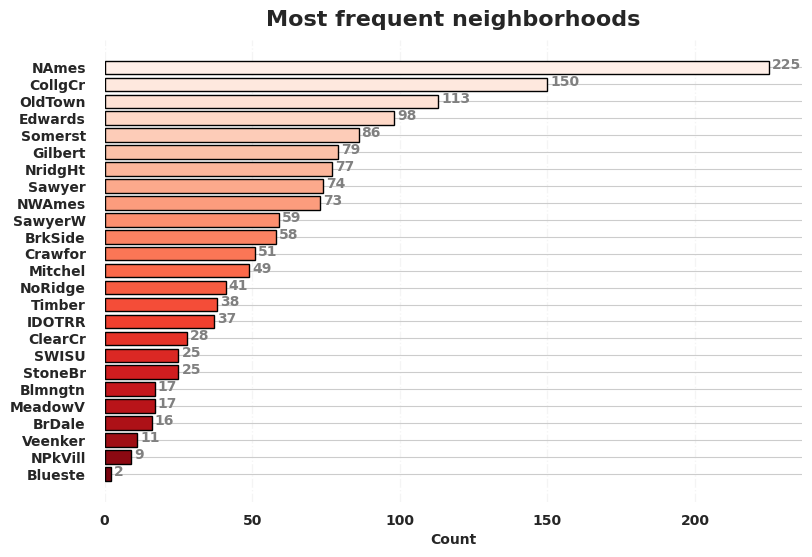

In [48]:
horizontal_plot(df, 'Neighborhood', 'Reds', 'Most frequent neighborhoods')

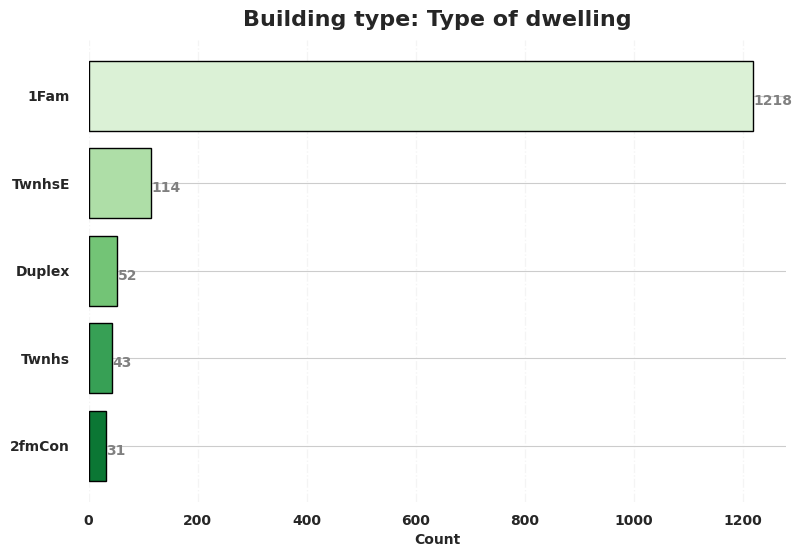

In [49]:
horizontal_plot(df, 'BldgType', 'Greens', 'Building type: Type of dwelling')

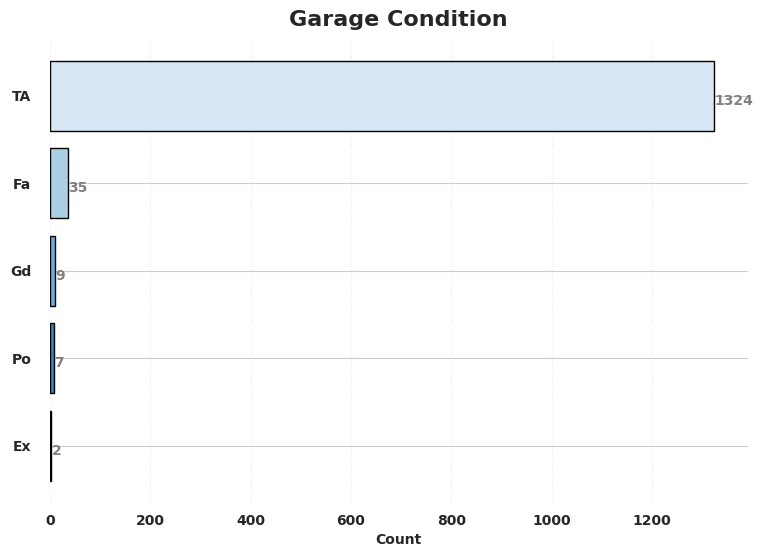

In [50]:
horizontal_plot(df, 'GarageCond', 'Blues', 'Garage Condition')

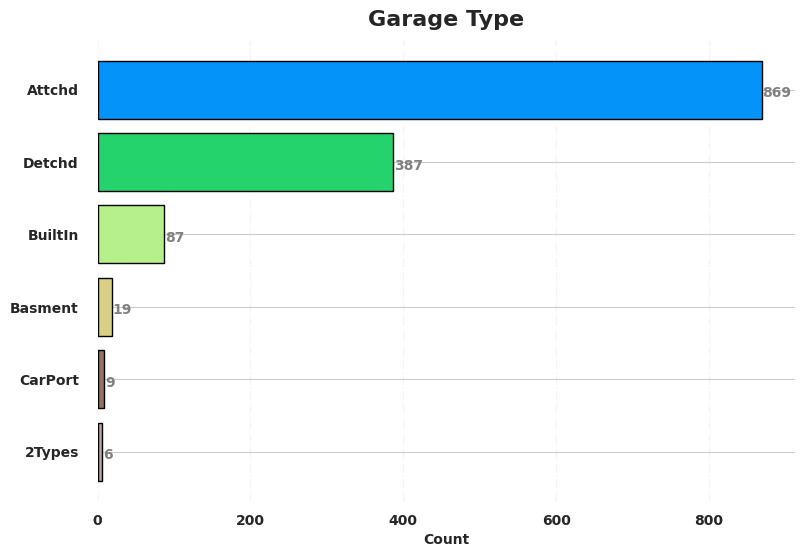

In [51]:
horizontal_plot(df, 'GarageType', 'terrain', 'Garage Type')

In [52]:
y = df['SalePrice'].reset_index(drop = True)
train_features = df.drop('SalePrice', axis = 1)
test_features = test.copy()

features = pd.concat((train_features, test_features)).reset_index(drop = True)

In [53]:
features.shape

(2917, 79)

In [54]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['MoSold'] = features['MoSold'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)

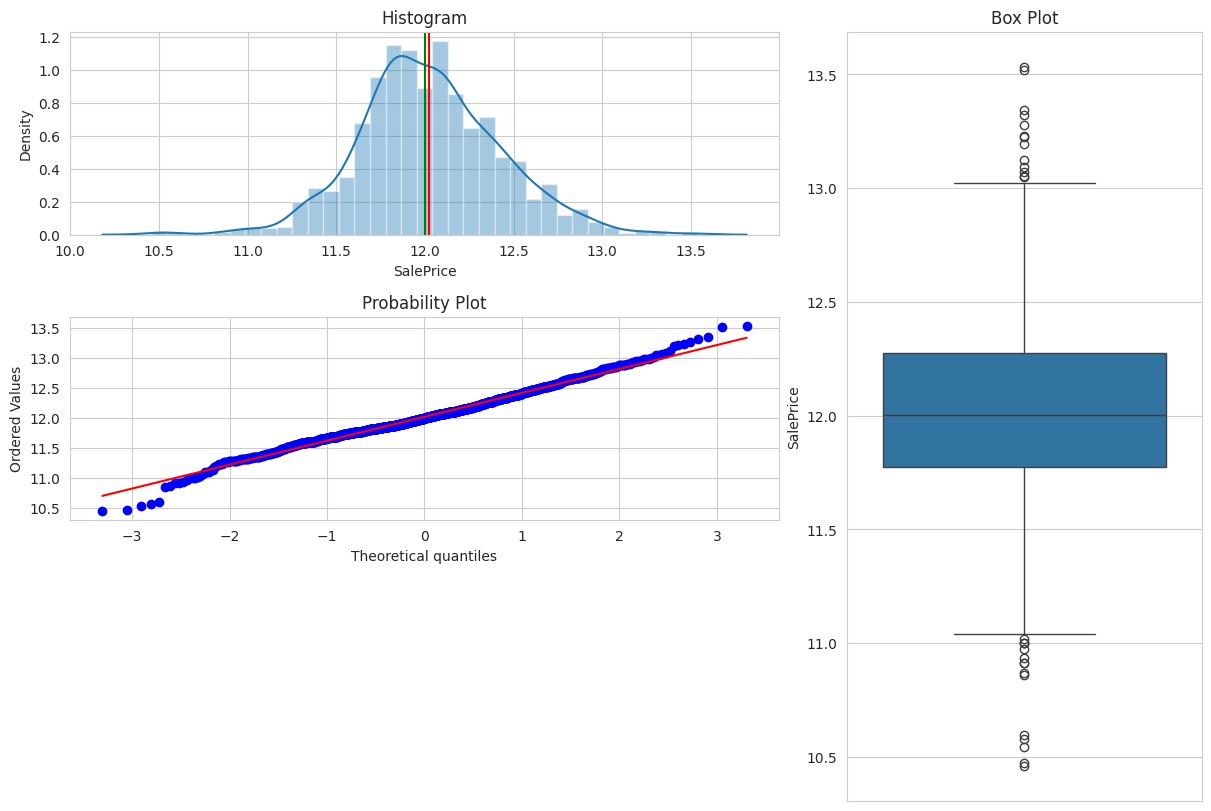

In [55]:
three_chart_plot(df, 'SalePrice')

In [56]:
null_table(features).sort_values(by = 'Approximate Percentage of Null Values').tail(10)


,Columns,Count of Null Values,Approximate Percentage of Null Values
63,GarageCond,159,5.450806
59,GarageFinish,159,5.450806
62,GarageQual,159,5.450806
2,LotFrontage,486,16.660953
56,FireplaceQu,1420,48.680151
24,MasVnrType,1766,60.541652
72,Fence,2346,80.425094
5,Alley,2719,93.212204
73,MiscFeature,2812,96.400411
71,PoolQC,2908,99.691464


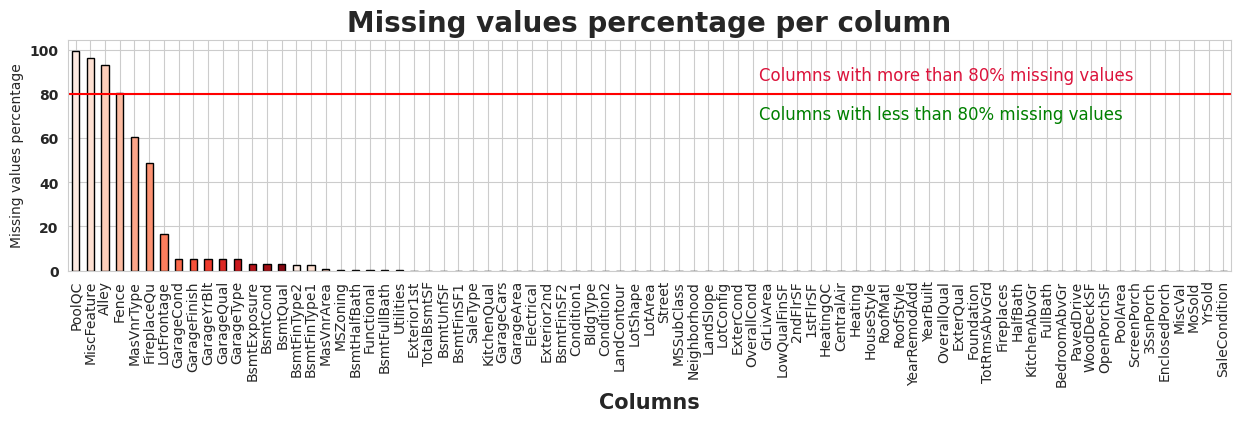

In [57]:
msv_1(features, 80, color = sns.color_palette('Reds',15))

In [58]:
features = features.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)
features.shape

(2917, 75)

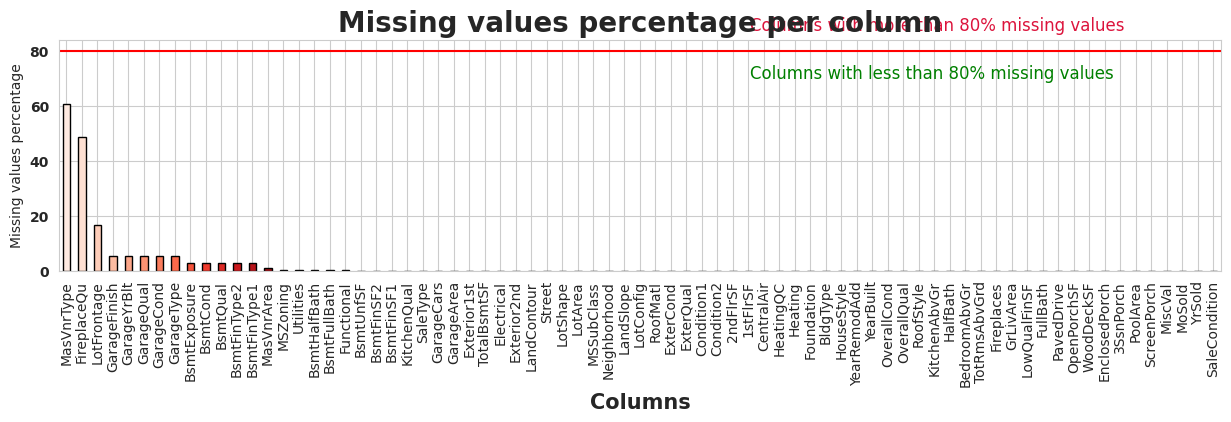

In [59]:
msv_1(features, 80, color = sns.color_palette('Reds',15))


In [62]:
description = open("/content/data_description.txt", "r")
print(description.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [63]:
def filling_null(features):

    # In the description for 'Functional Feature', it is given that Typ refers to the Typical Functionality
    # We will replace null values in the 'Functional' feature with 'Typ'

    features['Functional'] = features['Functional'].fillna('Typ')

    # Replace the null values in the below columns with their mode. We are replacing with mode because
    # all of these features are categorical variable, we can't take the mean nor the median.

    features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

    features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])

    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

    # In order to fill the null values for MSZoing, we will take into account the MSSubClass featue.
    # We are doing so because the type of dwelling in a given area largely affects the zone of the area.

    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

    # In order to fill the null values for LotFrontage(Linear feet of street connected to property)
    # we will fill it with median of the values grouped by Neighborhood.

    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # As mentioned before that the 'NA' value in many columns represent the absence of that feature for
    # a particular house, we will replace those null values with None.
    # 'None' for categorical feature and 0 for numerical feature.

    cat_features = features.select_dtypes(include = 'object').columns
    num_features = features.select_dtypes(exclude = 'object').columns

    features[cat_features] = features[cat_features].fillna('None')
    features[num_features] = features[num_features].fillna(0)

    return features

In [64]:
features = filling_null(features)
features.shape

(2917, 75)

In [65]:
features.isnull().sum().sum()


np.int64(0)

In [66]:
def new_features(features):

    features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x : 1 if x > 0 else 0)
    features['HasGarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    features['HasBsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    # Adding total sqfootage features
    # In order to get the total area of the house we have to add the basement area, 1st floor area and 2nd floor area.

    features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

    # Total number of bathrooms = number of full bathrooms + 0.5 * number of half bathrooms
    # + number of bathrooms in basement + 0.5 * number of half bathrooms in the basement.

    features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                                   features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

    features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                                  features['EnclosedPorch'] + features['ScreenPorch'])

    # Add years since remodel
    features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)

    return features

In [67]:
features = new_features(features)
features.shape

(2917, 84)

In [68]:
num_features = features.select_dtypes(exclude = 'object').columns

skewed_features = features[num_features].apply(lambda x : x.skew()).sort_values(ascending = False)
skew_features = pd.DataFrame({'Skew Value' : skewed_features})

skew_features.head(10)

,Skew Value
MiscVal,21.950962
PoolArea,17.697766
HasPool,15.502729
LotArea,13.116240
LowQualFinSF,12.090757
3SsnPorch,11.377932
KitchenAbvGr,4.302763
BsmtFinSF2,4.146636
EnclosedPorch,4.004404
ScreenPorch,3.947131


In [79]:
from sklearn.preprocessing import PowerTransformer

def fix_skew(features):
    numerical_cols = features.select_dtypes(exclude='object').columns
    skewed_feats = features[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5].index

    transformer = PowerTransformer(method='yeo-johnson', standardize=False)

    # Apply transformation only on skewed columns
    features[high_skew] = transformer.fit_transform(features[high_skew])

    return features


In [80]:
features = fix_skew(features)
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleCondition,HasPool,Has2ndFloor,HasGarage,HasBsmt,HasFireplace,TotalSF,Total_Bathrooms,Total_porch_sf,YearsSinceRemodel
0,60,RL,20.767314,17.941175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,Normal,-0.0,1,3.912919e+06,2.039053e+14,0,35.879415,3.5,6.643120,5
1,20,RL,23.855714,18.387385,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,Normal,-0.0,0,3.912919e+06,2.039053e+14,1,35.672627,2.5,0.000000,31
2,60,RL,21.404124,18.953064,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,Normal,-0.0,1,3.912919e+06,2.039053e+14,1,36.552580,3.5,5.788831,6
3,70,RL,19.681741,18.368969,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,Abnorml,-0.0,1,3.912919e+06,2.039053e+14,1,35.418370,2.0,11.288622,36
4,60,RL,24.642609,19.822022,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,Normal,-0.0,1,3.912919e+06,2.039053e+14,1,39.348654,3.5,7.435610,8


In [81]:
eatures = pd.get_dummies(features).reset_index(drop=True)
features.shape

(2917, 84)

In [82]:
X = features.iloc[:len(y), :]
test = features.iloc[len(y):, :]

In [83]:
X.shape, test.shape, y.shape

((1458, 84), (1459, 84), (1458,))

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [102]:
def evaluation(model, x_train_std, y_train, x_test, y_test, train = True):
    if train == True:
        pred = model.predict(x_train_std)

        print("Train Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, pred))}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mean_squared_error(y_train, pred)}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: \n{mean_absolute_error(y_train, pred)}")
        print("_______________________________________________")

    print()

    if train == False:
        pred = model.predict(x_test)

        print("Test Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, pred))}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mean_squared_error(y_test, pred)}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: \n{mean_absolute_error(y_test, pred)}")
        print("_______________________________________________")

In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming X and y are already defined
# For example:
# X = your dataframe with features (some categorical)
# y = your target variable series

# 1. Convert categorical variables to numeric using one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# 2. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.25, random_state=0
)

# 3. Scale the features (recommended for Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Define evaluation function
def evaluation(model, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = model.predict(X_train)
        print("Train Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, pred)):.4f}")
        print(f"Mean Squared Error: {mean_squared_error(y_train, pred):.4f}")
        print(f"Mean Absolute Error: {mean_absolute_error(y_train, pred):.4f}")
        print("________________________________________________\n")
    else:
        pred = model.predict(X_test)
        print("Test Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, pred)):.4f}")
        print(f"Mean Squared Error: {mean_squared_error(y_test, pred):.4f}")
        print(f"Mean Absolute Error: {mean_absolute_error(y_test, pred):.4f}")
        print("________________________________________________\n")

# 5. Fit Lasso model on scaled data
ls = Lasso(alpha=0.1)
ls.fit(X_train_scaled, y_train)

# 6. Evaluate
evaluation(ls, X_train_scaled, y_train, X_test_scaled, y_test, train=True)
evaluation(ls, X_train_scaled, y_train, X_test_scaled, y_test, train=False)


Train Result:
Root Mean Squared Error: 0.2023
Mean Squared Error: 0.0409
Mean Absolute Error: 0.1457
________________________________________________

Test Result:
Root Mean Squared Error: 0.1951
Mean Squared Error: 0.0381
Mean Absolute Error: 0.1439
________________________________________________



In [116]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.1)
ridge.fit(X_train, y_train)

evaluation(ridge, X_train, y_train, X_test, y_test, True)
evaluation(ridge, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.0868
Mean Squared Error: 0.0075
Mean Absolute Error: 0.0605
________________________________________________

Test Result:
Root Mean Squared Error: 0.1139
Mean Squared Error: 0.0130
Mean Absolute Error: 0.0816
________________________________________________



In [119]:
import numpy as np
import pandas as pd

# Check for infinite values
print(np.isinf(X_train).sum())       # total inf values in X_train
print(np.isinf(X_test).sum())        # total inf values in X_test

# Check for NaNs as well
print(X_train.isnull().sum().sum())  # total NaNs in X_train
print(X_test.isnull().sum().sum())   # total NaNs in X_test

# Replace infinite values with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Now fill NaNs (including original NaNs and replaced infs)
X_train.fillna(X_train.median(), inplace=True)  # or use .mean()
X_test.fillna(X_test.median(), inplace=True)

# Optional: scale features (recommended)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now fit XGBoost on cleaned data
import xgboost as xgb
xgb_regress = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1)
xgb_regress.fit(X_train_scaled, y_train)

# Then evaluate
evaluation(xgb_regress, X_train_scaled, y_train, X_test_scaled, y_test, train=True)
evaluation(xgb_regress, X_train_scaled, y_train, X_test_scaled, y_test, train=False)


LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 280, dtype: int64
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 280, dtype: int64
0
0
Train Result:
Root Mean Squared Error: 0.0014
Mean Squared Error: 0.0000
Mean Absolute Error: 0.0009
________________________________________________

Test Result:
Root Mean Squared Error: 0.1236
Mean Squared Error: 0.0153
Mean Absolute Error: 0.0920
________________________________________________

